# Demo Variational Inference on Sequential Monte Carlo Objectives

In [1]:
import tensorflow as tf

/Users/antoniomoretti/anaconda3/envs/miniphd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/antoniomoretti/anaconda3/envs/miniphd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import numpy as np
import pickle
import json
import sys
from datetime import datetime
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
#os.chdir("/Users/antoniomoretti/PycharmProjects/NormFlows/VISMC-master.11.7.18/SMC_time_invariant_MLP")
os.chdir("/Users/antoniomoretti/PycharmProjects/NormFlows/VISMC-11.29")

In [6]:
from MLP import MLP_mvn

In [7]:
from distributions import mvn, tf_mvn
from SMC_bootstrap import SMC
from rslts_saving import create_RLT_DIR, NumpyEncoder, plot_training_data, plot_learning_results, plot_losses

## Load Data

In [8]:
datadir = '/Users/antoniomoretti/Desktop/dhern-ts_wcommona-b4b1ad88b3aa/data/fitzhughnagumo/'

In [9]:
# load data
with open(datadir + "datadict", 'rb') as handle:
    data = pickle.load(handle, encoding='latin1')

obs_train = data['Ytrain']
obs_test = data['Yvalid']
hidden_train = data['Xtrue'][0:80]
hidden_test = data['Xtrue'][80:100]

In [10]:
Dy, Dx = obs_train.shape[2], hidden_train.shape[2]
time = obs_train.shape[1]
n_train = obs_train.shape[0]
n_test = obs_test.shape[0]

## Plot Ground Truth Latent Paths and Dynamics

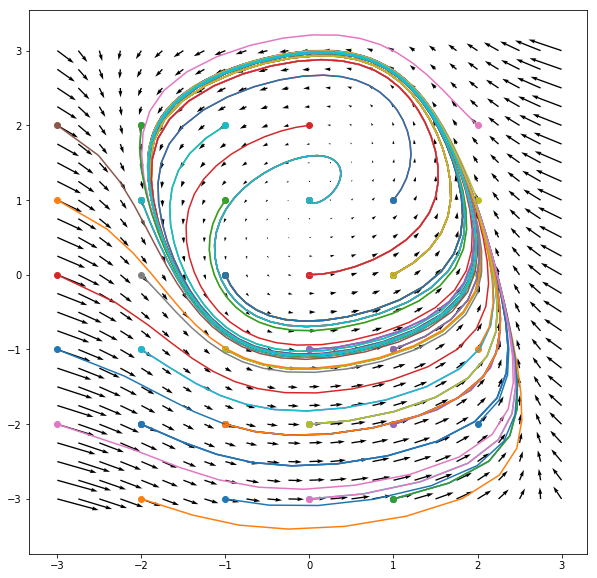

In [11]:
def f(Y, t, I,a,b,c):
    # Euler discretization
    y1, y2 = Y
    return [y1 - (y1**3)/3 - y2 + I, a*(b*y1 - c*y2)]
    #return [y1 - (y1**3)/3 - y2, 0.08*(y1 + 0.7 - 0.8*y2)+I]
        
# plot phase portraint of the ODE system
y1 = np.linspace(-3.0, 3.0, 25)
y2 = np.linspace(-3.0, 3.0, 25)
Y1, Y2 = np.meshgrid(y1, y2)
tau = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape
        
for i in range(NI):
    for j in range(NJ):
        x = Y1[i,j]
        y = Y2[i,j]
        yprime = f([x,y], tau,I=1,a=1,b=.95,c=.05)
        u[i,j] = yprime[0]
        v[i,j] = yprime[1]

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, color = 'black')
for p in hidden_train:
    plt.plot(p[:,0], p[:,1])
    plt.scatter(p[0,0], p[0,1])

## Plot First 20 Observations

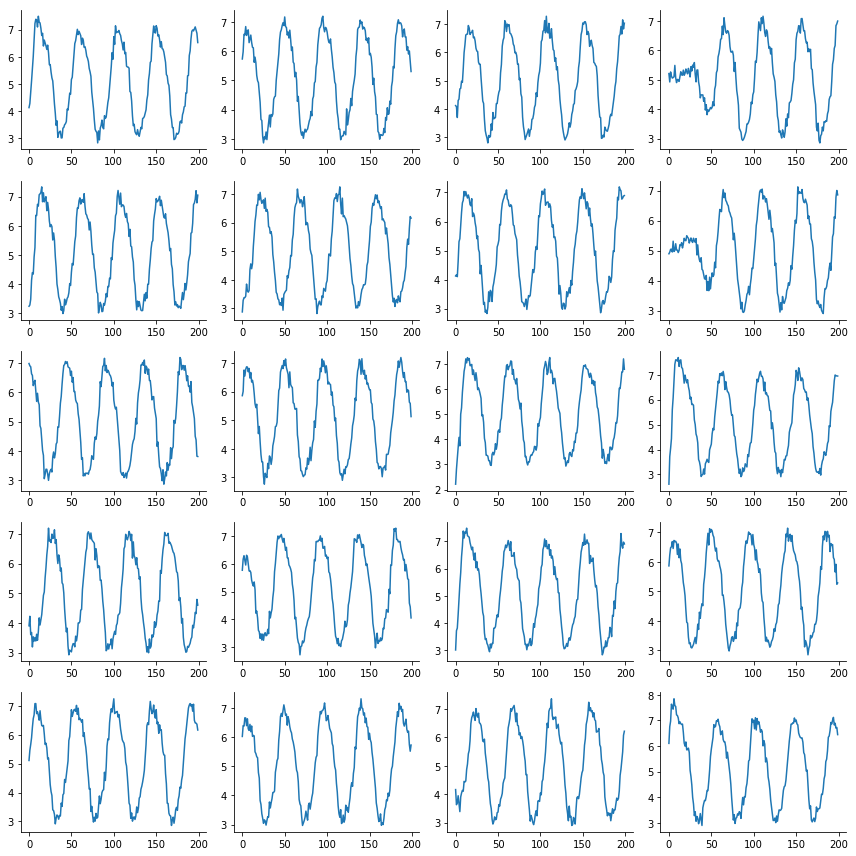

In [12]:
plt.figure(figsize=(12,12))
plt.title("Training Time Series")
plt.xlabel("Time")
for i in range(20):
    plt.subplot(5,4,i+1)
    #plt.plot(hidden_train[i], c='red')
    plt.plot(obs_train[i])
sns.despine()
plt.tight_layout()

## Hyperparameters

In [13]:
n_particles = 500
batch_size = 5
lr = 1e-3
epoch = 200
seed = 0

In [14]:
print_freq = 10
store_res = True
save_freq = 50
max_fig_num = 20
rslt_dir_name = 'time_invariant_MLP_fhn_1D_Dev'

In [15]:
# Parameters to initialize the covariance of the proposal distribution
ProposalCovInit = 10
ProposalCovMin = 1

In [16]:
tf.set_random_seed(seed)
np.random.seed(seed)

In [17]:
# create dir to store results
if store_res == True:
    Experiment_params = {"n_particles": n_particles, "time": time, "batch_size": batch_size,
                         "lr": lr, "epoch": epoch, "seed": seed, "n_train": n_train,
                         "rslt_dir_name": rslt_dir_name, "QCovInit": ProposalCovInit,
                         "QCovMin": ProposalCovMin}
    print('Experiment_params')
    for key, val in Experiment_params.items():
        print('\t{}:{}'.format(key, val))
    RLT_DIR = create_RLT_DIR(Experiment_params)
    print("RLT_DIR:", RLT_DIR)

Experiment_params
	n_particles:500
	time:200
	batch_size:5
	lr:0.001
	epoch:200
	seed:0
	n_train:80
	rslt_dir_name:time_invariant_MLP_fhn_1D_Dev
	QCovInit:10
	QCovMin:1
RLT_DIR: /Users/antoniomoretti/PycharmProjects/NormFlows/VISMC-11.29/rslts/time_invariant_MLP_fhn_1D_Dev/_D181130_1459_n_particles_500_time_200_batch_size_5_lr_0.001_epoch_200_seed_0_n_train_80_QCovInit_10_QCovMin_1/


## TensorFlow

In [18]:
# placeholders
obs = tf.placeholder(tf.float32, shape=(batch_size, time, Dy), name='obs')
x_0 = tf.placeholder(tf.float32, shape=(batch_size, Dx), name='x_0')

In [ ]:
#q_train = MLP_mvn(Dx + Dy, Dx, n_particles, batch_size, sigma_init=ProposalCovInit, sigma_min=ProposalCovMin, name='q_train')
f_train = MLP_mvn(Dx, Dx, n_particles, batch_size, sigma_init=5, sigma_min=1, name='f_train')
g_train = MLP_mvn(Dx, Dy, n_particles, batch_size, sigma_init=1, sigma_min=1, name='g_train')
q_train = f_train

In [ ]:
# for train_op
#SMC_true = SMC(q_true, f_true, g_true, n_particles, batch_size, name='log_ZSMC_true')
SMC_train = SMC(q_train, f_train, g_train, n_particles, batch_size, name='log_ZSMC_train')
#log_ZSMC_true, log_true = SMC_true.get_log_ZSMC(obs, x_0)
log_ZSMC_train, log_train = SMC_train.get_log_ZSMC(obs, x_0)

In [ ]:
with tf.name_scope('train'):
    train_op = tf.train.AdamOptimizer(lr).minimize(-log_ZSMC_train)

if store_res == True:
    writer = tf.summary.FileWriter(RLT_DIR)
    saver = tf.train.Saver()

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
# for plotting
log_ZSMC_trains = []
log_ZSMC_tests = []

## Train Model and Check Evolution of Inferred Trajectories in Latent Space

In [ ]:
with tf.Session() as sess:
    sess.run(init)

    if store_res == True:
        writer.add_graph(sess.graph)

    #log_ZSMC_true_val = SMC_true.tf_accuracy(sess, log_ZSMC_true, obs, obs_train + obs_test, x_0,
    #                                         hidden_train + hidden_test)
    #print("log_ZSMC_true_val: {:<7.3f}".format(log_ZSMC_true_val))
    """
    log_ZSMC_train_val = SMC_train.tf_accuracy(sess, log_ZSMC_train, obs, obs_train, x_0, hidden_train)
    log_ZSMC_test_val = SMC_train.tf_accuracy(sess, log_ZSMC_train, obs, obs_train, x_0, hidden_train)
    print("iter {:>3}, train log_ZSMC: {:>7.3f}, test log_ZSMC: {:>7.3f}" \
          .format(0, log_ZSMC_train_val, log_ZSMC_test_val))
    log_ZSMC_trains.append(log_ZSMC_train_val)
    log_ZSMC_tests.append(log_ZSMC_test_val)
    """
    for i in range(epoch):
        start_time = datetime.now()
        print("Epoch ", i)
        # train A, B, Q, x_0 using each training sample
        obs_train, hidden_train = shuffle(obs_train, hidden_train)
        for j in range(0, len(obs_train), batch_size):
            sess.run(train_op, feed_dict={obs: obs_train[j:j + batch_size],
                                          x_0: [hidden[0] for hidden in hidden_train[j:j + batch_size]]})
            

        # print training and testing loss
        if (i + 1) % print_freq == 0:
            """
            log_ZSMC_train_val = SMC_train.tf_accuracy(sess, log_ZSMC_train, obs, obs_train, x_0, hidden_train)
            log_ZSMC_test_val = SMC_train.tf_accuracy(sess, log_ZSMC_train, obs, obs_train, x_0, hidden_train)
            print("iter {:>3}, train log_ZSMC: {:>7.3f}, test log_ZSMC: {:>7.3f}" \
                  .format(i + 1, log_ZSMC_train_val, log_ZSMC_test_val))

            log_ZSMC_trains.append(log_ZSMC_train_val)
            log_ZSMC_tests.append(log_ZSMC_test_val)
            """
            SMC_train.plot_flow(sess, log_train[0], obs, obs_train, x_0, hidden_train, i, RLT_DIR=RLT_DIR)

        if store_res == True and (i + 1) % save_freq == 0:
            saver.save(sess, os.path.join(RLT_DIR, 'model/model_epoch'), global_step=i + 1)

        end_time = datetime.now()
        print("Duration:", (end_time - start_time))

    Xs = log_train[0]
    Xs_val = np.zeros((n_train, time, n_particles, Dx))
    for i in range(0, min(len(hidden_train), max_fig_num), batch_size):
        X_val = sess.run(Xs, feed_dict={obs: obs_train[i:i + batch_size],
                                        x_0: [hidden[0] for hidden in hidden_train[i:i + batch_size]]})
        for j in range(batch_size):
            Xs_val[i + j] = X_val[:, :, j, :]

sess.close()

Epoch  0
Duration: 0:06:27.561084
Epoch  1
Duration: 0:00:28.181566
Epoch  2
Duration: 0:00:28.084506
Epoch  3
Duration: 0:00:29.757144
Epoch  4
Duration: 0:00:31.965064
Epoch  5
Duration: 0:00:33.414777
Epoch  6
Duration: 0:00:32.613146
Epoch  7
Duration: 0:00:31.702038
Epoch  8
Duration: 0:00:31.620421
Epoch  9
Xdata.shape  (200, 5, 2)
axes.get_xlim <bound method _AxesBase.get_xlim of <matplotlib.axes._subplots.AxesSubplot object at 0x1b042f19e8>>
x1range, x2range (1.0905312955379487, 4.780030661821366) (-7.423001208426208, -0.4839485000027601)
Duration: 0:02:44.127349
Epoch  10
Duration: 0:00:27.790416
Epoch  11
Duration: 0:00:29.248269
Epoch  12
Duration: 0:00:29.991311
Epoch  13
Duration: 0:00:29.477450
Epoch  14
Duration: 0:00:28.124134
Epoch  15
Duration: 0:00:28.652301
Epoch  16
Duration: 0:00:28.299889
Epoch  17
Duration: 0:00:30.008483
Epoch  18
Duration: 0:00:29.110049
Epoch  19
Xdata.shape  (200, 5, 2)
axes.get_xlim <bound method _AxesBase.get_xlim of <matplotlib.axes._subp